In [12]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {'Yes' if tf.config.list_physical_devices('GPU') else 'No'}")

TensorFlow Version: 2.12.0
GPU Available: No


In [ ]:
DATA_DIR = '../data/'
TRAIN_LR_DIR = os.path.join(DATA_DIR, 'train/lr')
TRAIN_HR_DIR = os.path.join(DATA_DIR, 'train/hr')
VAL_LR_DIR = os.path.join(DATA_DIR, 'val/lr')
VAL_HR_DIR = os.path.join(DATA_DIR, 'val/hr')
TEST_LR_DIR = os.path.join(DATA_DIR, 'test/lr')
TEST_HR_DIR = os.path.join(DATA_DIR, 'test/hr')


LR_SIZE = (64, 64)
HR_SIZE = (256, 256)
UPSCALE_FACTOR = 4
CHANNELS = 3
RESIDUAL_BLOCKS = 8
FILTERS = 64


LEARNING_RATE = 1e-4
BATCH_SIZE = 8 
EPOCHS = 40

In [14]:
def psnr(y_true, y_pred):
    """
    Peak Signal-to-Noise Ratio metric.
    Assumes input images are in the range [0, 1].
    """
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [ ]:
def residual_block(x, filters):
    """A single residual block for the EDSR model."""
    res = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    res = Conv2D(filters, (3, 3), padding='same')(res)
    x = Add()([x, res])
    return x

def upsampling_block(x, filters):
    """Upsampling block using sub-pixel convolution (tf.nn.depth_to_space)."""
    x = Conv2D(filters * 4, (3, 3), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2)
    return x

def build_edsr_like_model(lr_shape, channels, residual_blocks, filters):
    """Builds the EDSR-like super-resolution model."""
    inputs = Input(shape=(lr_shape[0], lr_shape[1], channels))
    
    x = inputs
    x = Conv2D(filters, (3, 3), padding='same')(x)
    conv1_out = x

    for _ in range(residual_blocks):
        x = residual_block(x, filters)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = Add()([conv1_out, x])

    x = upsampling_block(x, filters)
    x = upsampling_block(x, filters)
    
    outputs = Conv2D(channels, (3, 3), padding='same', activation='sigmoid')(x)

    model = Model(inputs, outputs, name="EDSR_like_SuperResolution")
    return model

model = build_edsr_like_model(
    lr_shape=LR_SIZE,
    channels=CHANNELS,
    residual_blocks=RESIDUAL_BLOCKS,
    filters=FILTERS
)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mae',
    metrics=[psnr]
)

model.summary()

Model: "EDSR_like_SuperResolution"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 64, 64, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 64, 64, 64)   36928       ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 64, 64, 64)   36928       ['conv2d_43[0][0]']              
                                                                          

In [ ]:
def load_and_preprocess(lr_path, hr_path, augment=False):
    """
    Loads and preprocesses a single LR/HR image pair.
    If 'augment' is True, applies the SAME random flips and rotations to both images.
    """
    lr_img = tf.io.read_file(lr_path)
    lr_img = tf.image.decode_png(lr_img, channels=3)
    lr_img = tf.image.convert_image_dtype(lr_img, tf.float32)

    hr_img = tf.io.read_file(hr_path)
    hr_img = tf.image.decode_png(hr_img, channels=3)
    hr_img = tf.image.convert_image_dtype(hr_img, tf.float32)

    if augment:
        if tf.random.uniform(()) > 0.5:
            lr_img = tf.image.flip_left_right(lr_img)
            hr_img = tf.image.flip_left_right(hr_img)

        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        lr_img = tf.image.rot90(lr_img, k=k)
        hr_img = tf.image.rot90(hr_img, k=k)
        
    return lr_img, hr_img

def create_dataset(lr_dir, hr_dir, batch_size):
    """Creates a tf.data.Dataset, enabling augmentation for the training set."""
    lr_paths = sorted(glob.glob(os.path.join(lr_dir, "*.png")))
    hr_paths = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
    
    if not lr_paths or not hr_paths:
        raise ValueError(f"No images found in directories: {lr_dir}, {hr_dir}")

    dataset = tf.data.Dataset.from_tensor_slices((lr_paths, hr_paths))
    
    is_training = 'train' in lr_dir
    dataset = dataset.map(lambda lr, hr: load_and_preprocess(lr, hr, augment=is_training), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(lr_paths))
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train_ds = create_dataset(TRAIN_LR_DIR, TRAIN_HR_DIR, BATCH_SIZE)
val_ds = create_dataset(VAL_LR_DIR, VAL_HR_DIR, BATCH_SIZE)
test_ds = create_dataset(TEST_LR_DIR, TEST_HR_DIR, BATCH_SIZE)

print("--- Datasets created successfully with augmentation for the training set ---")
print(f"Training dataset:   {train_ds}")
print(f"Validation dataset: {val_ds}")
print(f"Test dataset:       {test_ds}")

--- Datasets created successfully with augmentation for the training set ---
Training dataset:   <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>
Test dataset:       <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None))>


In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

model.save('super_resolution_model.h5')

Epoch 1/40
8/8 [==============================] - 11s 1s/step - loss: 0.2565 - psnr: 10.7845 - val_loss: 0.2586 - val_psnr: 10.9047
Epoch 2/40
8/8 [==============================] - 8s 1s/step - loss: 0.2240 - psnr: 11.9552 - val_loss: 0.2029 - val_psnr: 12.5880
Epoch 3/40
8/8 [==============================] - 8s 1s/step - loss: 0.1729 - psnr: 13.4583 - val_loss: 0.1761 - val_psnr: 13.2966
Epoch 4/40
8/8 [==============================] - 8s 1s/step - loss: 0.1505 - psnr: 14.5063 - val_loss: 0.1431 - val_psnr: 15.3056
Epoch 5/40
8/8 [==============================] - 8s 1s/step - loss: 0.1311 - psnr: 15.4666 - val_loss: 0.1332 - val_psnr: 15.7443
Epoch 6/40
8/8 [==============================] - 8s 1s/step - loss: 0.1275 - psnr: 15.7206 - val_loss: 0.1201 - val_psnr: 16.6059
Epoch 7/40
8/8 [==============================] - 8s 1s/step - loss: 0.1119 - psnr: 16.7382 - val_loss: 0.1004 - val_psnr: 17.7722
Epoch 8/40
8/8 [==============================] - 8s 1s/step - loss: 0.1093 - psnr

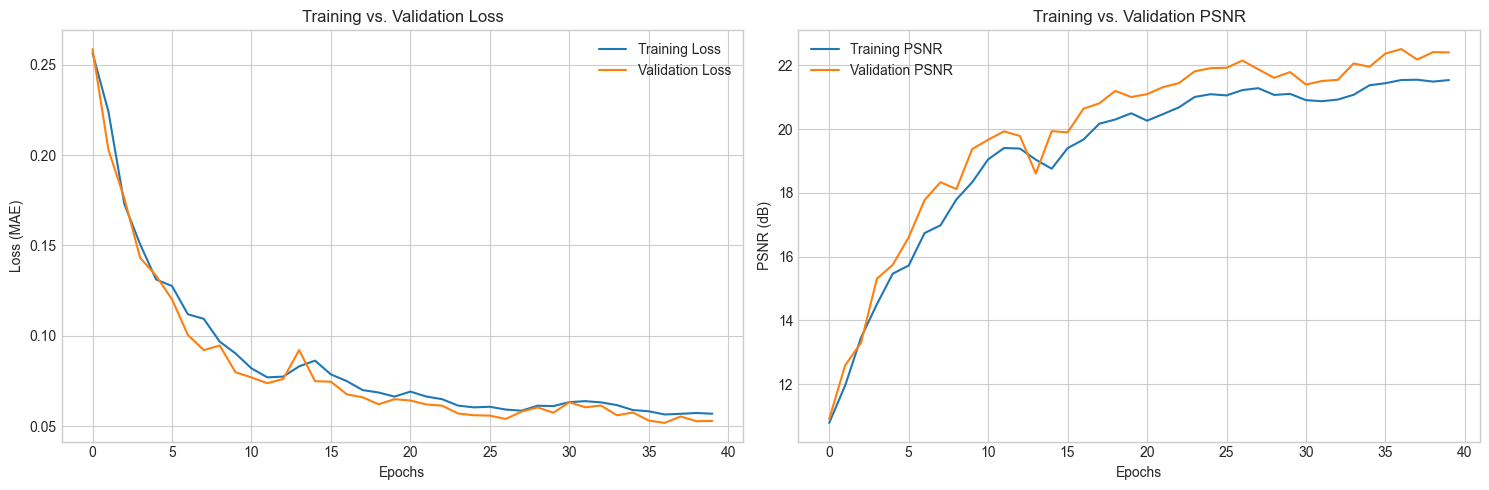

In [ ]:
def plot_history(history):
    """Plots the training and validation loss and PSNR."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Training vs. Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss (MAE)')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['psnr'], label='Training PSNR')
    axes[1].plot(history.history['val_psnr'], label='Validation PSNR')
    axes[1].set_title('Training vs. Validation PSNR')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('PSNR (dB)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [19]:
print("Evaluating final model on the unseen test set...")
results = model.evaluate(test_ds, verbose=1)

print("\n--- Test Set Evaluation ---")
print(f"Test Loss (MAE): {results[0]:.4f}")
print(f"Test PSNR (dB):  {results[1]:.4f}")
print("---------------------------")

Evaluating final model on the unseen test set...
3/3 [==============================] - 1s 202ms/step - loss: 0.0484 - psnr: 23.1315

--- Test Set Evaluation ---
Test Loss (MAE): 0.0484
Test PSNR (dB):  23.1315
---------------------------


1/1 [==============================] - 0s 419ms/step


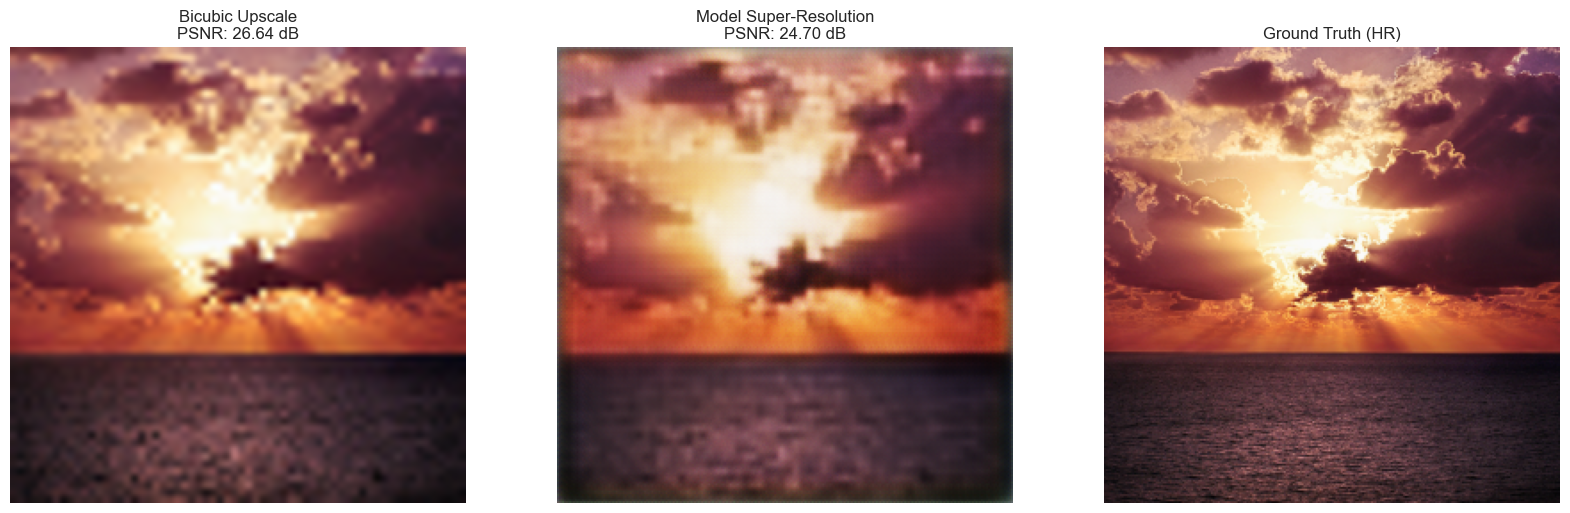

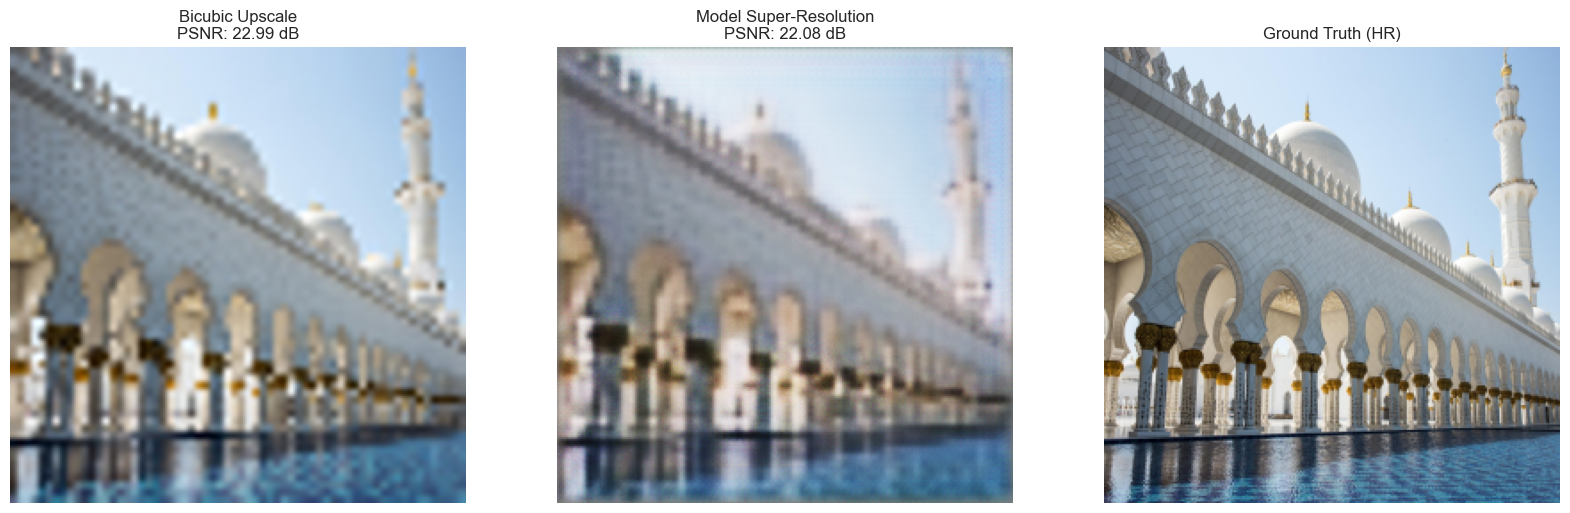

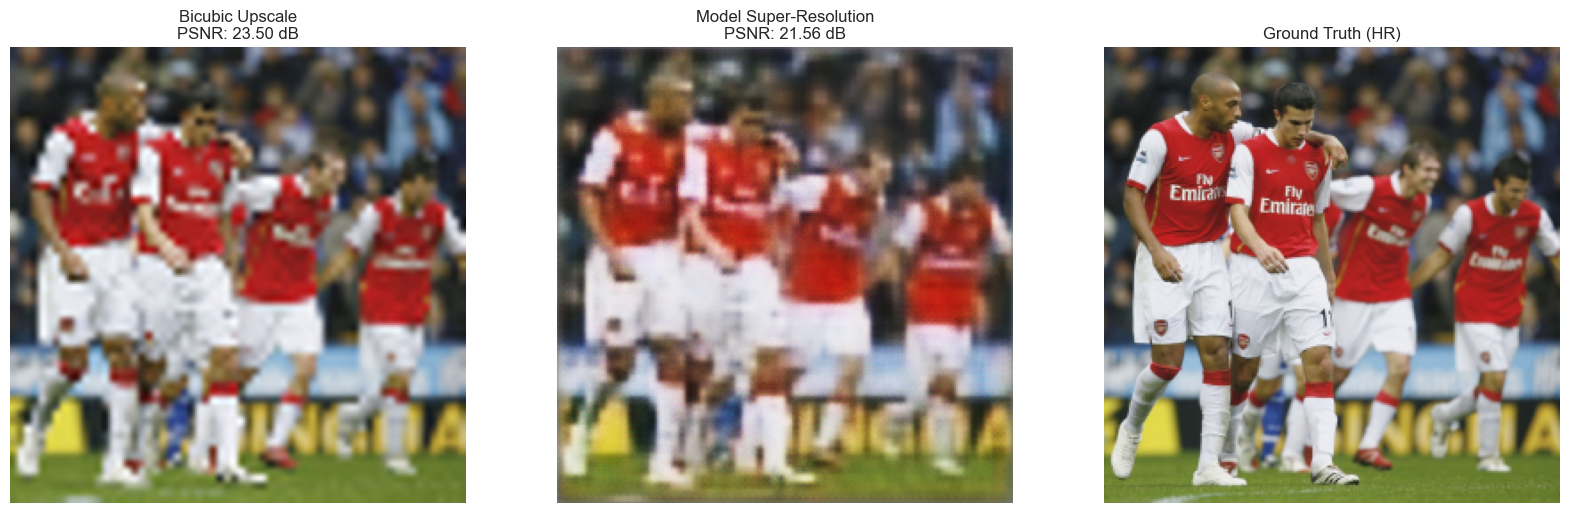

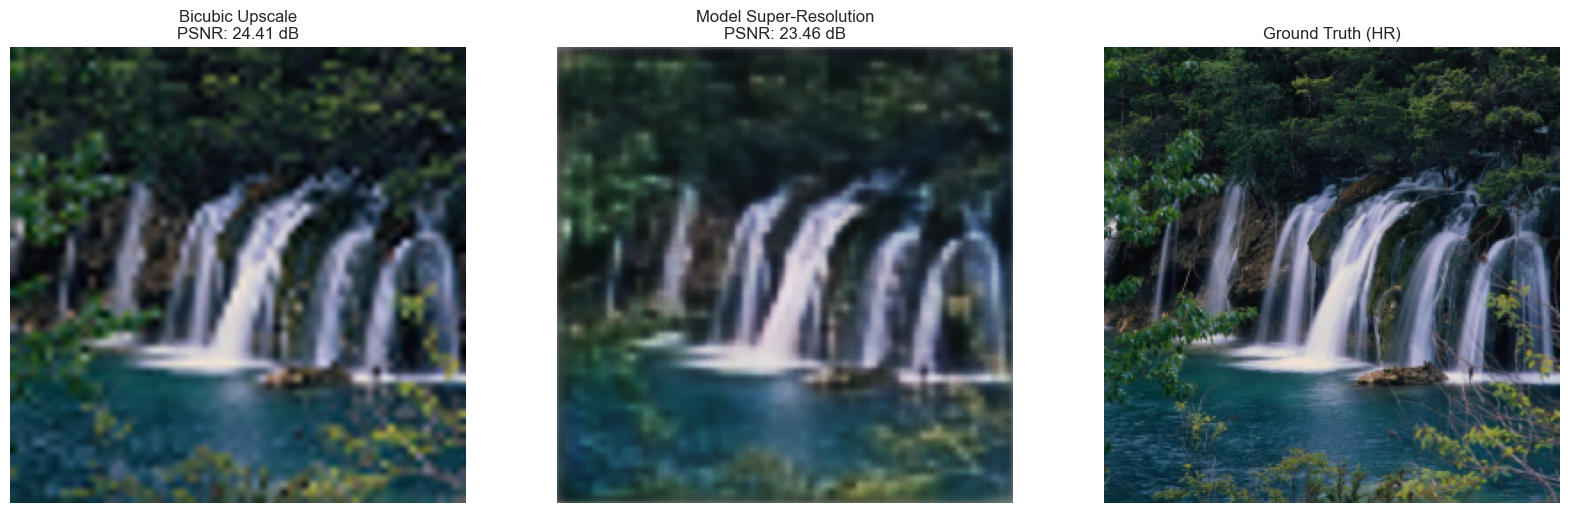

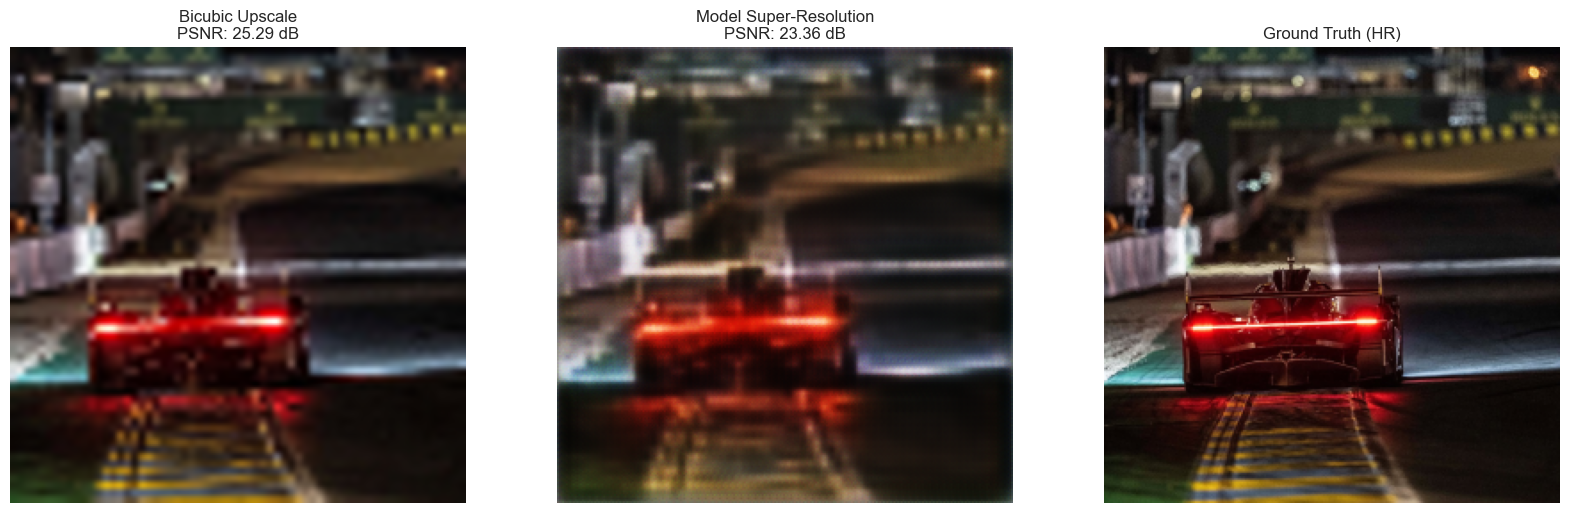

In [ ]:
def plot_test_results(model, dataset, num_images_to_show=5):
    """Displays a side-by-side comparison of Bicubic, Model SR, and Ground Truth."""
    for lr_batch, hr_batch in dataset.take(1):
        sr_batch = model.predict(lr_batch)

        for i in range(min(num_images_to_show, len(lr_batch))):
            lr_img = lr_batch[i].numpy()
            sr_img = sr_batch[i]
            hr_img = hr_batch[i].numpy()

            bicubic_img = tf.image.resize(lr_img, HR_SIZE, method='bicubic').numpy()

            bicubic_img = np.clip(bicubic_img, 0.0, 1.0)
            sr_img = np.clip(sr_img, 0.0, 1.0)
            hr_img = np.clip(hr_img, 0.0, 1.0)

            psnr_bicubic = tf.image.psnr(tf.convert_to_tensor(bicubic_img), tf.convert_to_tensor(hr_img), max_val=1.0).numpy()
            psnr_model = tf.image.psnr(tf.convert_to_tensor(sr_img), tf.convert_to_tensor(hr_img), max_val=1.0).numpy()

            fig, axes = plt.subplots(1, 3, figsize=(20, 7))
            
            axes[0].imshow(bicubic_img)
            axes[0].set_title(f'Bicubic Upscale\nPSNR: {psnr_bicubic:.2f} dB')
            axes[0].axis('off')

            axes[1].imshow(sr_img)
            axes[1].set_title(f'Model Super-Resolution\nPSNR: {psnr_model:.2f} dB')
            axes[1].axis('off')

            axes[2].imshow(hr_img)
            axes[2].set_title('Ground Truth (HR)')
            axes[2].axis('off')

            plt.show()

plot_test_results(model, test_ds, num_images_to_show=5)